In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_geometric.nn import MessagePassing, DenseGCNConv, DenseGraphConv, global_mean_pool, ASAPooling, GATv2Conv, GCNConv
from torch_geometric.utils import add_self_loops, degree
import numpy as np
import torch
import os.path as osp
import torch
from torch.nn import Linear

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GraphConv, dense_mincut_pool
from torch_geometric import utils
from torch_geometric.nn import Sequential
from torch_geometric.nn.conv.gcn_conv import gcn_norm

In [3]:
class GraphConv(MessagePassing):
    def __init__(self, num_features, hidden_channels):
        super(GraphConv, self).__init__(aggr='mean')
        self.lin1 = nn.Linear(num_features, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, hidden_channels)
        self.pool = ASAPooling(hidden_channels, dropout=0.3)

    def forward(self, x,  edge_index, batch=None):
        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)

        # Step 3: Start propagating messages.
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        x = self.propagate(edge_index, x=x, norm=norm)

        # Step 4: Return output.
        x = self.pool(x)
        # x = F.relu(x)
        # x = global_mean_pool(x, batch) # global mean pooling
        return x

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # No additional update.
        return aggr_out

In [4]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(4, 1600)
        self.conv2 = GCNConv(160, 6)

    def forward(self, data, batch=None):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return x


In [16]:
train_loader = torch.load( '../export/train_loader.pt')
test_loader = torch.load( '../export/test_loader.pt')

In [10]:
xt = torch.load( '../export/train_split.pt')

In [14]:
dl = torch.load( '../export/train_loader.pt')

In [15]:
class Net(torch.nn.Module):
    def __init__(self,
                 mp_units,
                 mp_act,
                 in_channels,
                 n_clusters,
                 mlp_units=[],
                 mlp_act="Identity"):
        super().__init__()

        mp_act = getattr(torch.nn, mp_act)(inplace=True)
        mlp_act = getattr(torch.nn, mlp_act)(inplace=True)

        # Message passing layers
        mp = [
            (GraphConv(in_channels, mp_units[0]), 'x, edge_index, edge_weight -> x'),
            mp_act
        ]
        for i in range(len(mp_units) - 1):
            mp.append((GraphConv(mp_units[i], mp_units[i + 1]), 'x, edge_index, edge_weight -> x'))
            mp.append(mp_act)
        self.mp = Sequential('x, edge_index, edge_weight', mp)
        out_chan = mp_units[-1]

        # MLP layers
        self.mlp = torch.nn.Sequential()
        for units in mlp_units:
            self.mlp.append(Linear(out_chan, units))
            out_chan = units
            self.mlp.append(mlp_act)
        self.mlp.append(Linear(out_chan, n_clusters))

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        edge_weight = None
        # Propagate node feats
        x = self.mp(x, edge_index, edge_weight)

        # Cluster assignments (logits)
        s = self.mlp(x)

        # Obtain MinCutPool losses
        adj = utils.to_dense_adj(edge_index, edge_attr=edge_weight)
        _, _, mc_loss, o_loss = dense_mincut_pool(x, adj, s)

        return torch.softmax(s, dim=-1), mc_loss, o_loss

In [16]:
model = Net([16], "ELU", 4, 6)

In [17]:
gr = next(iter(dl))

In [18]:
model(gr).shape

(tensor([[0.1329, 0.2692, 0.2351, 0.0650, 0.1526, 0.1452],
         [0.1397, 0.2507, 0.2157, 0.0728, 0.1711, 0.1500],
         [0.1397, 0.2507, 0.2157, 0.0728, 0.1711, 0.1500],
         ...,
         [0.1398, 0.2505, 0.2152, 0.0730, 0.1713, 0.1502],
         [0.1398, 0.2506, 0.2153, 0.0729, 0.1713, 0.1502],
         [0.1398, 0.2506, 0.2152, 0.0729, 0.1713, 0.1502]],
        grad_fn=<SoftmaxBackward0>),
 tensor(-0.9973, grad_fn=<MeanBackward0>),
 tensor(1.0871, grad_fn=<MeanBackward0>))

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GCN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()
model.train()
train_loss = []
for epoch in range(100):
    for graph in train_loader:
        graph.to(device)
        optimizer.zero_grad()
        out = model(graph)
        y = graph.y.to(device)
        loss = loss_fn(out.view(-1), y)
        loss.backward()
        optimizer.step()
        print(loss.item())
        train_loss.append(loss.item())



cpu


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'torch_geometric.data.data.Data'>

In [ ]:
model.eval()
test_losses = []
test_accu = []
for graph in test_loader:
        graph.to(device)
        out = model(graph)
        y = graph.y.to(device)
        test_losses.append(loss_fn(out.view(-1), y).item())
        test_accu.append((out.argmax(dim=1) == y.argmax()).item())

In [ ]:
np.mean(test_losses)

In [ ]:
np.sum(test_accu)/len(test_accu)

In [ ]:
model(test_loader)

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_loss)

In [ ]:
gr = next(iter(train_loader))

In [ ]:
gr.y.type(torch.LongTensor).argmax()

In [20]:
model(test_loader)

AttributeError: 'DataLoader' object has no attribute 'x'

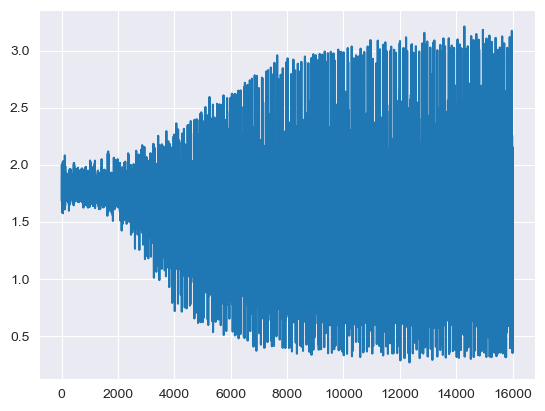

In [18]:
from matplotlib import pyplot as plt
plt.plot(train_loss)

In [8]:
gr = next(iter(train_loader))

In [11]:
gr.y.type(torch.LongTensor).argmax()

tensor(0)

In [16]:
gr.y.shape

torch.Size([6])

In [50]:
with torch.autocast('cuda'):
    out = gc(gr.x.float(), gr.edge_index)

In [51]:
out.shape

torch.Size([14833, 100])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data.x, data.adj, data.mask)
        loss = F.nll_loss(output, data.y.view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.adj, data.mask)[0].max(dim=1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()
    return correct / len(loader.dataset)



In [10]:
gcn1 = DenseGCNConv(42225, 4)
grc = DenseGraphConv(42225, 4)

In [11]:
gcn1(data.x, data.edge_index)

RuntimeError: The size of tensor a (252532) must match the size of tensor b (2) at non-singleton dimension 2

In [44]:
Net(data.x, data.edge_index)

tensor([[0.1374]], grad_fn=<MeanBackward1>)

In [18]:
gcn1(data.x, data.edge_index)

RuntimeError: The size of tensor a (252532) must match the size of tensor b (2) at non-singleton dimension 2